In [ ]:
import pandas as pd
import numpy as np
!pip install statsmodels

import statsmodels.api as sm
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()


[notice] A new release of pip is available: 23.0.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


## Data Import (*fruit only)

In [ ]:
fruit2 = pd.read_csv("Raw Data/fruit_2.csv")
fruit2 = fruit2[["year", "commodity", "loss_percentage"]].groupby(["year", "commodity"]).min().reset_index()
fruit2 = fruit2[fruit2["year"] >= 2000]
fruit2.head()

,year,commodity,loss_percentage
350,2000,Apple juice,26.6667
351,2000,Apples,4.0000
352,2000,Apricots,9.0000
353,2000,Blueberries,8.0000
354,2000,Cantaloupes and other melons,8.0000


In [ ]:
foodYield = pd.read_csv("Raw Data/FoodYield.csv")
foodYield.head()

,Domain Code,Domain,Area Code (M49),Area,Element Code,Element,Item Code (CPC),Item,Year Code,Year,Unit,Value,Flag,Flag Description,Note
0,QCL,Crops and livestock products,840,United States of America,5419,Yield,1371.0,"Almonds, in shell",2000,2000,100 g/ha,26342,A,Official figure,NaN
1,QCL,Crops and livestock products,840,United States of America,5419,Yield,1371.0,"Almonds, in shell",2001,2001,100 g/ha,28402,A,Official figure,NaN
2,QCL,Crops and livestock products,840,United States of America,5419,Yield,1371.0,"Almonds, in shell",2002,2002,100 g/ha,36275,A,Official figure,NaN
3,QCL,Crops and livestock products,840,United States of America,5419,Yield,1371.0,"Almonds, in shell",2003,2003,100 g/ha,35325,A,Official figure,NaN
4,QCL,Crops and livestock products,840,United States of America,5419,Yield,1371.0,"Almonds, in shell",2004,2004,100 g/ha,34074,A,Official figure,NaN


In [ ]:
foodYield = foodYield.rename(columns={"Value":"crop_yield"})
foodYield = foodYield[["Year", "Item", "crop_yield"]]
fruits_am = pd.merge(fruit2, foodYield, how='left', left_on=['year', 'commodity'], right_on=['Year', 'Item'])
fruits_am = fruits_am[["year", "commodity", "loss_percentage", "crop_yield"]].dropna()
fruits_am.head()

,year,commodity,loss_percentage,crop_yield
1,2000,Apples,4.0,273483.0
2,2000,Apricots,9.0,106579.0
3,2000,Blueberries,8.0,51253.0
4,2000,Cantaloupes and other melons,8.0,230769.0
5,2000,Cranberries,4.0,172109.0


In [ ]:
fruits_am["lost_crop_yield"] = (fruits_am["loss_percentage"]/100) * fruits_am["crop_yield"]
fruits_am["year"] = pd.to_datetime(fruits_am["year"].astype(str), format='%Y')
fruits_am.head()

,year,commodity,loss_percentage,crop_yield,lost_crop_yield
1,2000-01-01,Apples,4.0,273483.0,10939.32
2,2000-01-01,Apricots,9.0,106579.0,9592.11
3,2000-01-01,Blueberries,8.0,51253.0,4100.24
4,2000-01-01,Cantaloupes and other melons,8.0,230769.0,18461.52
5,2000-01-01,Cranberries,4.0,172109.0,6884.36


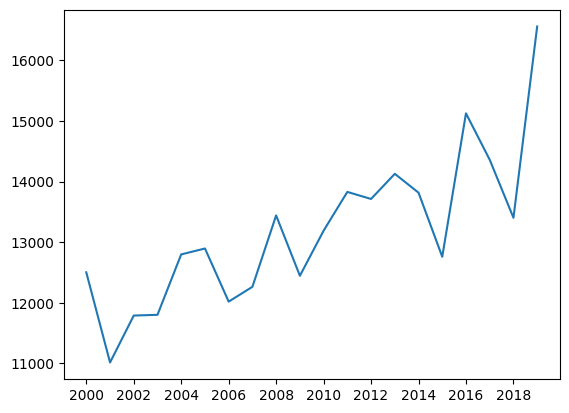

In [ ]:
f_group_am = fruits_am.groupby("year").median()[["lost_crop_yield"]] #note choice of median crop yield here
plt.plot(f_group_am)

## Stationarity

In [ ]:
def get_stationarity(time_series):
    rolling_mean = time_series.rolling(window=4).mean()
    rolling_std = time_series.rolling(window=4).std()

    # rolling statistics plot
    original = plt.plot(time_series, color='blue', label='Original')
    mean = plt.plot(rolling_mean, color='red', label='Rolling Mean')
    std = plt.plot(rolling_std, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    # Dickey–Fuller test:
    result = adfuller(time_series['lost_crop_yield'])
    print('ADF Statistic: {}'.format(result[0]))
    print('p-value: {}'.format(result[1]))
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))

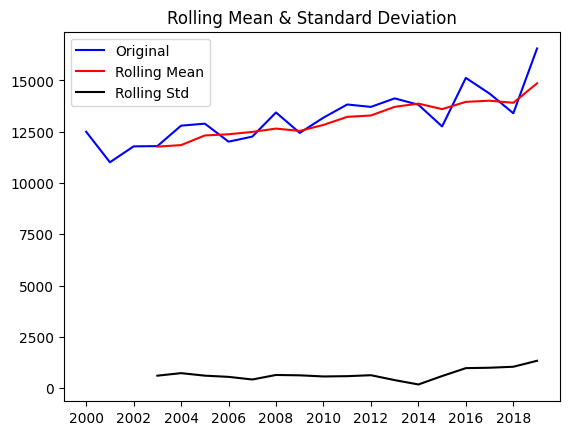

ADF Statistic: -0.4524523450229775
p-value: 0.9009659245433874
Critical Values:
	1%: -4.223238279489106
	5%: -3.189368925619835
	10%: -2.729839421487603


In [ ]:
get_stationarity(f_group_am)

Indicators time series is NOT stationary:

- Rolling mean and rolling STD are still increasing over time, not flat

- P-value of ADF is well above cutoff of 0.05

Because it is not stationary, we need to find some sort of way to convert it to a stationary series before performing ARIMAX => this helps us conclude one of the parameters of the ARIMAX model, d (marks # of steps needed for time series to be converted to a stationary series)

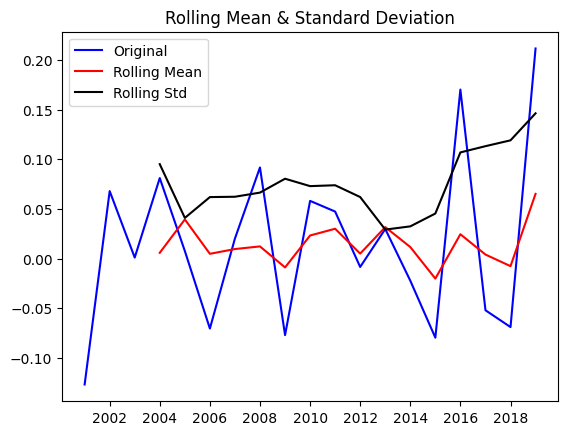

ADF Statistic: -2.7471188327065494
p-value: 0.06623348215215262
Critical Values:
	1%: -4.223238279489106
	5%: -3.189368925619835
	10%: -2.729839421487603


In [ ]:
# logged, and shifted
f_am_log = np.log(f_group_am)
f_am_s = f_am_log - f_am_log.shift()
f_am_s.dropna(inplace=True)

get_stationarity(f_am_s)

Now:

- Rolling mean & rolling std much smoother

- P-value is WELL below critical values

In other words: much more stationary! Another way we can check this is through correlograms (ACF & PACF test).

## ARIMA (no exogenous)

In [ ]:
f_group_am.index

DatetimeIndex(['2000-01-01', '2001-01-01', '2002-01-01', '2003-01-01',
               '2004-01-01', '2005-01-01', '2006-01-01', '2007-01-01',
               '2008-01-01', '2009-01-01', '2010-01-01', '2011-01-01',
               '2012-01-01', '2013-01-01', '2014-01-01', '2015-01-01',
               '2016-01-01', '2017-01-01', '2018-01-01', '2019-01-01'],
              dtype='datetime64[ns]', name='year', freq=None)

In [ ]:
# create train/test split so we can see how accurate our model is
tr_start,tr_end = '1985-01-01','2014-01-01'
te_start,te_end = '2015-01-01','2020-01-01'
tra = f_group_am["lost_crop_yield"][tr_start:tr_end].dropna()
tes = f_group_am["lost_crop_yield"][te_start:te_end].dropna()

In [ ]:
!pip install pmdarima
#This is to determine the order of the ARIMA model
from pmdarima import auto_arima

# Fit an auto ARIMA model to determine the best parameters (p, d, q)
auto_arima_model = auto_arima(f_group_am)

# Get the summary of the auto ARIMA model
print(auto_arima_model.summary())


[notice] A new release of pip is available: 23.0.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   20
Model:               SARIMAX(2, 1, 2)   Log Likelihood                -153.856
Date:                Tue, 05 Dec 2023   AIC                            319.713
Time:                        00:49:19   BIC                            325.379
Sample:                    01-01-2000   HQIC                           320.672
                         - 01-01-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    434.6916    208.700      2.083      0.037      25.647     843.736
ar.L1         -0.1

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.31480D+00    |proj g|=  8.58037D-01

At iterate    5    f=  5.93777D+00    |proj g|=  2.19071D-01

At iterate   10    f=  5.78125D+00    |proj g|=  1.52168D-01

At iterate   15    f=  5.75715D+00    |proj g|=  5.34636D-04

At iterate   20    f=  5.75714D+00    |proj g|=  5.12245D-04

At iterate   25    f=  5.75688D+00    |proj g|=  8.55592D-03

At iterate   30    f=  5.73711D+00    |proj g|=  5.27358D-02

At iterate   35    f=  5.73283D+00    |proj g|=  2.74915D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

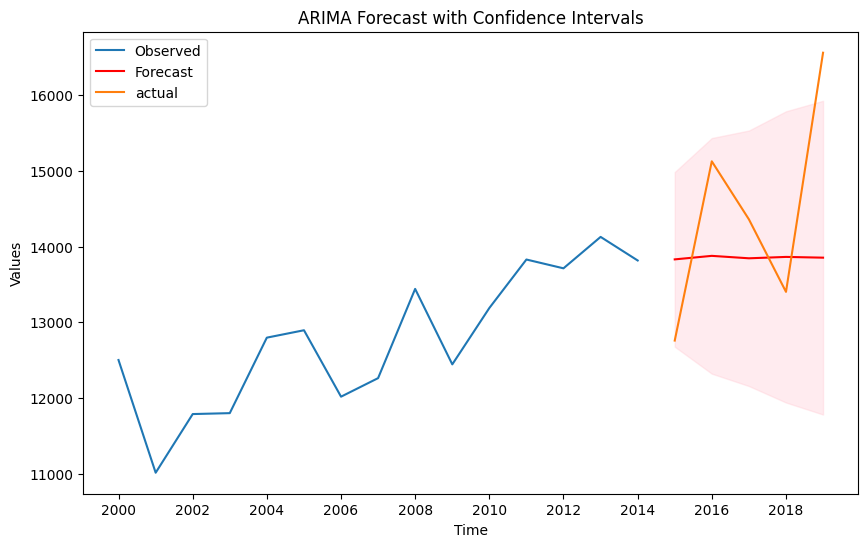

RMSE:  1449.9662353152148


In [ ]:
model = SARIMAX(tra, order=(2, 1, 2),enforce_invertibility=False, enforce_stationarity=False)
results = model.fit()

# Forecast future periods (change 'steps' to the number of periods you want to forecast)
forecast = results.get_forecast(steps=5)  # For example, forecasting 10 steps ahead

# Extract confidence intervals for the forecast
confidence_intervals = forecast.conf_int()

# Plot the forecasted values
plt.figure(figsize=(10, 6))
plt.plot(tra.index, tra.values, label='Observed')  # Assuming 'data' is a pandas Series or DataFrame

# Plot the forecasted values
plt.plot(forecast.predicted_mean.index, forecast.predicted_mean.values, color='red', label='Forecast')

# Shade the confidence interval
plt.fill_between(
    confidence_intervals.index,
    confidence_intervals.iloc[:, 0],
    confidence_intervals.iloc[:, 1],
    color='pink',  # Adjust the color as needed
    alpha=0.3  # Adjust transparency if desired
)

plt.plot(tes.index, tes.values, label='actual')
plt.title('ARIMA Forecast with Confidence Intervals')
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend()
plt.show()

print("RMSE: ", np.mean((forecast.predicted_mean.values - tes.values)**2)**.5 )

## ARIMAX (exogenous)

Next steps:

- Find correlation with other variables from other df's, use the top few to train a new model and see if confidence interval reduces

- Also maybe try other orders of ARIMA?

- Apply ARIMAX to other products (veg, roots, animal prods)

In [ ]:
CO2 = pd.read_csv("Raw Data/CO2 Emissions.csv")
CO2['Year'] = pd.to_datetime(CO2['Year'].astype(str), format='%Y')
CO2.head()

,Year,CO2 Emissions
0,1990-01-01,19.407336
1,1991-01-01,19.003390
2,1992-01-01,19.022845
3,1993-01-01,19.218331
4,1994-01-01,19.256185


In [ ]:
fertilizers = pd.read_csv("Raw Data/Fertilizers.csv")
fertilizers['Year'] = pd.to_datetime(fertilizers['Year'].astype(str), format='%Y')
fertilizers = fertilizers.groupby("Year").mean()[["Value"]].reset_index()
fertilizers = fertilizers.rename(columns={"Value":"Fertilizer"})
fertilizers.head()

,Year,Fertilizer
0,1990-01-01,6.216512e+06
1,1991-01-01,6.238545e+06
2,1992-01-01,6.307994e+06
3,1993-01-01,6.632871e+06
4,1994-01-01,6.553303e+06


In [ ]:
gdp = pd.read_csv("Raw Data/GDP.csv")
gdp['Year'] = pd.to_datetime(gdp['Year'].astype(str), format='%Y')
gdp = gdp.rename(columns={"Value":"GDP"})
gdp.head()

,Domain Code,Domain,Area Code,Area,Element Code,Element,Item Code,Item,Year Code,Year,Unit,GDP,Flag,Flag Description
0,FS,Suite of Food Security Indicators,231,United States of America,6126,Value,22013,"Gross domestic product per capita, PPP, (const...",2000,2000-01-01,I$,50175.7,X,Figure from international organizations
1,FS,Suite of Food Security Indicators,231,United States of America,6126,Value,22013,"Gross domestic product per capita, PPP, (const...",2001,2001-01-01,I$,50155.7,X,Figure from international organizations
2,FS,Suite of Food Security Indicators,231,United States of America,6126,Value,22013,"Gross domestic product per capita, PPP, (const...",2002,2002-01-01,I$,50535.3,X,Figure from international organizations
3,FS,Suite of Food Security Indicators,231,United States of America,6126,Value,22013,"Gross domestic product per capita, PPP, (const...",2003,2003-01-01,I$,51503.8,X,Figure from international organizations
4,FS,Suite of Food Security Indicators,231,United States of America,6126,Value,22013,"Gross domestic product per capita, PPP, (const...",2004,2004-01-01,I$,52995.2,X,Figure from international organizations


In [ ]:
gni = pd.read_csv("Raw Data/united-states-gni-per-capita.csv")
gni['date'] = pd.to_datetime(gni['date']) + pd.Timedelta(days=1)
gni.head()

,date,GNI Per Capita (US $),Annual % Growth
0,1991-01-01,24060,1.22
1,1992-01-01,24270,0.87
2,1993-01-01,25680,5.81
3,1994-01-01,26390,2.76
4,1995-01-01,27650,4.77


In [ ]:
precipitation = pd.read_csv("Raw Data/Precipitation.csv")
precipitation['Year'] = pd.to_datetime(precipitation['Year'].astype(str), format='%Y')
precipitation.head()

,Year,Avg. Precipitation (inches)
0,1990-01-01,32.2
1,1991-01-01,32.4
2,1992-01-01,31.3
3,1993-01-01,32.6
4,1994-01-01,30.6


In [ ]:
a = pd.merge(f_group_am.reset_index(), CO2, how='left', left_on='year', right_on='Year')
b = pd.merge(a, fertilizers, how='left', left_on='year', right_on='Year')
c = pd.merge(b, gdp, how='left', left_on='year', right_on='Year')
d = pd.merge(c, precipitation, how='left', left_on='year', right_on='Year')
e = pd.merge(d, gni, how='left', left_on='year', right_on='date')
corr_tbl = e[["year", "lost_crop_yield", "CO2  Emissions", "Fertilizer", "GDP", "GNI Per Capita (US $)", "Annual % Growth", "Avg. Precipitation (inches)"]]
corr_tbl.corr()

,lost_crop_yield,CO2 Emissions,Fertilizer,GDP,GNI Per Capita (US $),Annual % Growth,Avg. Precipitation (inches)
lost_crop_yield,1.000000,-0.784275,0.151280,0.789689,0.797104,-0.059647,0.453195
CO2 Emissions,-0.784275,1.000000,-0.308472,-0.870719,-0.939983,0.319488,-0.557235
Fertilizer,0.151280,-0.308472,1.000000,0.228426,0.201661,0.111508,0.080597
GDP,0.789689,-0.870719,0.228426,1.000000,0.968606,-0.053854,0.664145
GNI Per Capita (US $),0.797104,-0.939983,0.201661,0.968606,1.000000,-0.174801,0.635135
Annual % Growth,-0.059647,0.319488,0.111508,-0.053854,-0.174801,1.000000,-0.022693
Avg. Precipitation (inches),0.453195,-0.557235,0.080597,0.664145,0.635135,-0.022693,1.000000


Looks like CO2, GDP, and GNI are the strongest correlated features => let's insure linear is the best way to depict their relationship

Text(0.5, 0, 'Lost Crop')

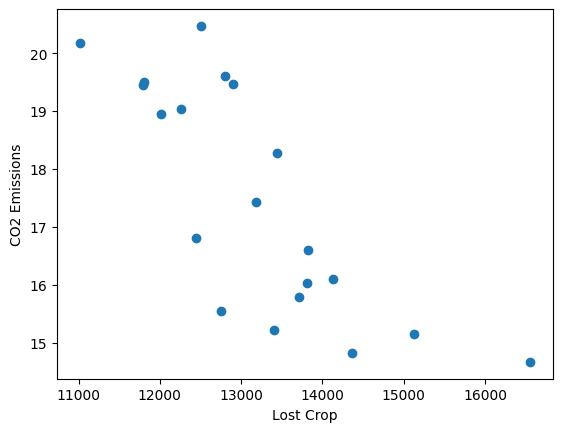

In [ ]:
plt.scatter(corr_tbl["lost_crop_yield"], corr_tbl["CO2  Emissions"])
plt.ylabel('CO2 Emissions')
plt.xlabel('Lost Crop')

Text(0, 0.5, 'GDP')

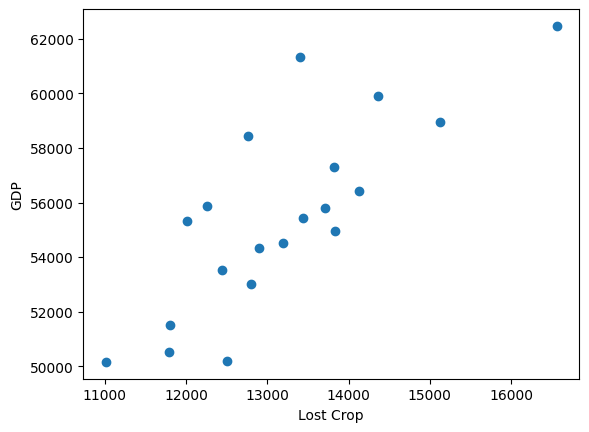

In [ ]:
plt.scatter(corr_tbl["lost_crop_yield"], corr_tbl["GDP"])
plt.xlabel('Lost Crop')
plt.ylabel('GDP')

Text(0, 0.5, 'GNI Per Capita')

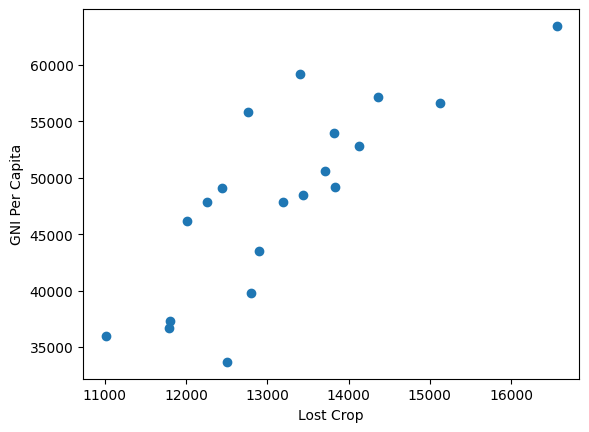

In [ ]:
plt.scatter(corr_tbl["lost_crop_yield"], corr_tbl["GNI Per Capita (US $)"])
plt.xlabel('Lost Crop')
plt.ylabel('GNI Per Capita')

In [ ]:
f_group_am

,lost_crop_yield
year,
2000-01-01,12501.675
2001-01-01,11013.045
2002-01-01,11787.780
2003-01-01,11799.940
2004-01-01,12796.960
2005-01-01,12894.710
2006-01-01,12017.450
2007-01-01,12262.330
2008-01-01,13440.835


In [ ]:
f_amx = f_group_am.loc['2000-01-01':'2015-01-01',:] #2000 to 2015
f_amx

,lost_crop_yield
year,
2000-01-01,12501.675
2001-01-01,11013.045
2002-01-01,11787.780
2003-01-01,11799.940
2004-01-01,12796.960
2005-01-01,12894.710
2006-01-01,12017.450
2007-01-01,12262.330
2008-01-01,13440.835


In [ ]:
f_amx.index

DatetimeIndex(['2000-01-01', '2001-01-01', '2002-01-01', '2003-01-01',
               '2004-01-01', '2005-01-01', '2006-01-01', '2007-01-01',
               '2008-01-01', '2009-01-01', '2010-01-01', '2011-01-01',
               '2012-01-01', '2013-01-01', '2014-01-01', '2015-01-01'],
              dtype='datetime64[ns]', name='year', freq=None)

In [ ]:
exog_x = corr_tbl[["year", "CO2  Emissions", "GDP", "GNI Per Capita (US $)"]]
exog_x = exog_x.set_index("year")
exog_x

,CO2 Emissions,GDP,GNI Per Capita (US $)
year,,,
2000-01-01,20.469797,50175.7,33680
2001-01-01,20.171537,50155.7,35960
2002-01-01,19.445530,50535.3,36700
2003-01-01,19.506506,51503.8,37310
2004-01-01,19.597617,52995.2,39750
2005-01-01,19.469273,54338.0,43510
2006-01-01,18.945917,55314.2,46180
2007-01-01,19.042912,55892.2,47830
2008-01-01,18.278491,55433.7,48500


In [ ]:
exog_x_tra = exog_x.loc["2000-01-01":"2015-01-01", :]
exog_x_tra

,CO2 Emissions,GDP,GNI Per Capita (US $)
year,,,
2000-01-01,20.469797,50175.7,33680
2001-01-01,20.171537,50155.7,35960
2002-01-01,19.445530,50535.3,36700
2003-01-01,19.506506,51503.8,37310
2004-01-01,19.597617,52995.2,39750
2005-01-01,19.469273,54338.0,43510
2006-01-01,18.945917,55314.2,46180
2007-01-01,19.042912,55892.2,47830
2008-01-01,18.278491,55433.7,48500


In [ ]:
exog_x_test = exog_x.loc["2016-01-01":"2019-01-01", :]
exog_x_test

,CO2 Emissions,GDP,GNI Per Capita (US $)
year,,,
2016-01-01,15.149883,58972.9,56620
2017-01-01,14.823245,59914.8,57140
2018-01-01,15.222518,61355.6,59220
2019-01-01,14.673381,62478.3,63460


In [ ]:
f_amx_test = f_group_am.loc["2016-01-01":"2019-01-01", :]
f_amx_test

,lost_crop_yield
year,
2016-01-01,15125.860
2017-01-01,14358.765
2018-01-01,13401.725
2019-01-01,16560.090


/root/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/root/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.90094D+00    |proj g|=  7.03763D-01

At iterate    5    f=  5.87448D+00    |proj g|=  1.03338D-01

At iterate   10    f=  5.87252D+00    |proj g|=  8.19434D-02

At iterate   15    f=  5.84763D+00    |proj g|=  2.71012D-01

At iterate   20    f=  5.82192D+00    |proj g|=  6.81501D-02

At iterate   25    f=  5.82038D+00    |proj g|=  4.40665D-03

           * * *

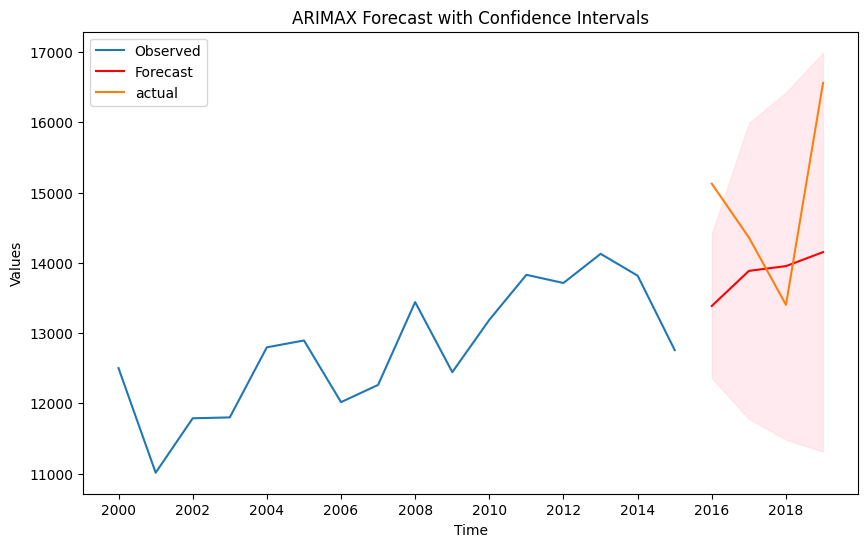

RMSE:  1529.5240241009517


In [ ]:
model_x = SARIMAX(f_amx, order=(2, 1, 2), exog=exog_x_tra[["GDP", "GNI Per Capita (US $)", "CO2  Emissions"]], enforce_invertibility=False, enforce_stationarity=False)
results_x = model_x.fit()

# Forecast future periods (change 'steps' to the number of periods you want to forecast)
forecast_x = results_x.get_forecast(steps=4, exog=exog_x_test[["GDP", "GNI Per Capita (US $)", "CO2  Emissions"]])  # For example, forecasting 10 steps ahead

# Extract confidence intervals for the forecast
confidence_intervals_x = forecast_x.conf_int()

# Plot the forecasted values
plt.figure(figsize=(10, 6))
plt.plot(f_amx.index, f_amx.values, label='Observed')  # Assuming 'data' is a pandas Series or DataFrame

# Plot the forecasted values
plt.plot(forecast_x.predicted_mean.index, forecast_x.predicted_mean.values, color='red', label='Forecast')
plt.plot(f_amx_test, label='actual')

# Shade the confidence interval
plt.fill_between(
    confidence_intervals_x.index,
    confidence_intervals_x.iloc[:, 0],
    confidence_intervals_x.iloc[:, 1],
    color='pink',  # Adjust the color as needed
    alpha=0.3  # Adjust transparency if desired
)

plt.title('ARIMAX Forecast with Confidence Intervals')
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend()
plt.show()

print("RMSE: ", np.mean((forecast_x.predicted_mean.values - f_amx_test["lost_crop_yield"])**2)**.5 )

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math

y_true = f_amx_test.values
y_pred = forecast_x.predicted_mean.values

# report performance
mse = mean_squared_error(y_true, y_pred)
print('MSE: '+str(mse))
mae = mean_absolute_error(y_true, y_pred)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(y_true, y_pred))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(y_pred - y_true)/np.abs(y_true))
print('MAPE: '+str(mape))

MSE: 2339443.740301969
MAE: 1293.4475868633795
RMSE: 1529.5240241009517
MAPE: 0.07956202482648135


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=342fa5dc-5dd2-4212-ac75-4267e7cc0cc3' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>